# Exercise 9 - Neural Network from Scratch

## Task
Implement a multilayer Fully Connected Network from scratch using Numpy. Use the class structure provided below. Four member functions are to be implemented:
- `forward(self, x)` for the forward prediction
- `backward(self, y)` for the backpropagation in order to compute the gradients
- `zero_grad(self)` to reset the gradients to zero (to be used before a second prediction/backpropagation)
- `step(self, lr)` to update the weights and biases with gradient descent

The most challenging task is to compute the gradients. Therefore split the implementation up into two steps:
- implement the gradient computation for a sample size of one
- implement the gradient computation for an arbitrary sample size (use the currentWeightGradients and currentBiasGradients to store the intermediate results)

To check the results, you can verify the gradients by comparing them to PyTorch. A code copying the custom neural network to PyTorch, where the automatic differentiation is provided below.

After a successful verification, use the neural network to learn a function. The training algorithm is provided below. Using the Adam optimizer implementation from exercise 2.3, the training can be improved. It is almost impossible to learn a sufficiently complex function with only gradient descent. 

Finally, compare the implementation to a PyTorch implementation.

## Learning Goals
- Gain a deeper understanding of each step in the fully connected network inference and backpropogation
- Practice matching tensor dimensions of each input and output

## Hints
Backward: 
- (3.14) $$\frac{\partial z^{(l)}_{j}}{\partial w^{(l)}_{jk}} = \frac{\partial}{\partial w^{(l)}_{jk}} \sum_h w^{(l)}_{jh} a^{(l-1)}_h + b^{(l)}_j = a^{(l-1)}_k$$ 

- (3.16) $$\frac{\partial C}{\partial b^{(l)}_j} = \frac{\partial C}{\partial z^{(l)}_{j}}\frac{\partial z^{(l)}_{j}}{\partial b^{(l)}_j} = \delta^{(l)}_j \frac{\partial z^{(l)}_{j}}{\partial b^{(l)}_j} = \delta^{(l)}_j$$

- (3.18) $$\delta^{(L)}_j = \frac{\partial C}{\partial z^{(L)}_j} = 
	\frac{\partial C}{\partial a^{(L)}_j}\frac{\partial a^{(L)}_j}{\partial z^{(L)}_j} =
	%	\frac{\partial}{\partial a^{(L)}_j} \frac{1}{2}(y_j - a^{(L)}_j)^2
	\frac{\partial C}{\partial a^{(L)}_j}\sigma'(z^{(L)}_j) = 
	-(\tilde{y}_j - \sigma(z^{(L)}_j))\sigma'(z^{(L)}_j)$$

- (3.23) 	$$\delta^{(l)}_j = \sum_k w^{(l+1)}_{kj}  \delta^{(l+1)}_k \sigma'(z^{(l)}_j)$$

Start by implementing the backward propagation for only a single sample. Subsequently, extend the implementations for an arbitrary number of samples. To this end, recall the definitions provided in
Equations 

(3.10) $$C = \frac{1}{m_{\mathcal{D}}}\sum_{i=1}^{m_{\mathcal{D}}}C_i$$

and (3.11)    $$C_i = \frac{1}{2}(\tilde{y}_i - \hat{y}_i)^2 = \frac{1}{2}(\tilde{y}_i - a_i^{(L)})^2$$

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

**neural network class**

In [2]:
class neuralNetwork:
    def __init__(
            self, layers, activation, activationGradient, xavierInitialization=True
    ):
        self.L = len(layers)  # number of layers
        if xavierInitialization == True:
            self.weights = [
                torch.nn.init.xavier_uniform_(
                    torch.zeros((layers[i], layers[i + 1])),
                    gain=torch.nn.init.calculate_gain("sigmoid"),
                ).numpy()
                for i in range(self.L - 1)
            ]
        else:
            self.weights = [
                np.random.rand(layers[i], layers[i + 1]) for i in range(self.L - 1)
            ]
        self.biases = [np.random.rand(1, layers[i + 1]) for i in range(self.L - 1)]

        self.layerActivations = []

        self.weightGradients = [
            np.zeros((layers[i], layers[i + 1])) for i in range(self.L - 1)
        ]
        self.biasGradients = [np.zeros((1, layers[i + 1])) for i in range(self.L - 1)]

        # helper variables to store gradients per sample
        self.currentWeightGradients = [
            np.zeros((layers[i], layers[i + 1])) for i in range(self.L - 1)
        ]
        self.currentBiasGradients = [
            np.zeros((1, layers[i + 1])) for i in range(self.L - 1)
        ]

        self.activation = activation
        self.activationGradient = activationGradient

    def forward(self, x):
        self.layerActivations = []  # clear activations
        a = x
        self.layerActivations.append(a)  # activation is not applied to input
        for i in range(self.L - 1):
            z = a @ self.weights[i] + self.biases[i]
            self.layerActivations.append(z)  # store activations
            a = self.activation(z)
        return a

    def backward(self, y):
        if len(self.layerActivations) > 0:  # check if forward pass has been performed
            numberOfSamples = len(self.layerActivations[0])

            # for a single sample
            if numberOfSamples == 1:
                deltaL = -(
                        y - self.activation(self.layerActivations[self.L - 1])
                ) * self.activationGradient(self.layerActivations[self.L - 1])
                self.biasGradients[self.L - 2] = deltaL
                for i in range(
                        self.L - 2
                ):  # indices of layer activation shifted due to stored input
                    deltal = np.sum(
                        self.weights[self.L - 2 - i]
                        * self.biasGradients[self.L - 2 - i],
                        1,
                    ) * self.activationGradient(self.layerActivations[self.L - 2 - i])
                    self.biasGradients[self.L - 3 - i] = deltal

                self.weightGradients[0] = (
                        np.transpose(self.layerActivations[0]) @ self.biasGradients[0]
                )  # without activation for input
                for i in range(1, self.L - 1):
                    self.weightGradients[i] = (
                            np.transpose(self.activation(self.layerActivations[i]))
                            @ self.biasGradients[i]
                    )

            # for multiple samples using for loop over samples
            elif numberOfSamples > 1:
                for j in range(numberOfSamples):

                    deltaL = -(
                            y[j: j + 1]
                            - self.activation(self.layerActivations[self.L - 1][j: j + 1])
                    ) * self.activationGradient(
                        self.layerActivations[self.L - 1][j: j + 1]
                    )
                    self.currentBiasGradients[self.L - 2] = (
                            deltaL / numberOfSamples
                    )  # division by number of samples, as we are taking the mean
                    self.biasGradients[self.L - 2] += self.currentBiasGradients[
                        self.L - 2
                        ]
                    for i in range(
                            self.L - 2
                    ):  # indices of layer activation shifted due to stored input
                        deltal = np.sum(
                            self.weights[self.L - 2 - i]
                            * self.currentBiasGradients[self.L - 2 - i],
                            1,
                        ) * self.activationGradient(
                            self.layerActivations[self.L - 2 - i][j: j + 1]
                        )
                        self.currentBiasGradients[self.L - 3 - i] = deltal
                        self.biasGradients[self.L - 3 - i] += self.currentBiasGradients[
                            self.L - 3 - i
                            ]

                    # without activation for input
                    self.currentWeightGradients[0] = (
                            np.transpose(self.layerActivations[0][j: j + 1])
                            @ self.currentBiasGradients[0]
                    )
                    self.weightGradients[0] += self.currentWeightGradients[0]
                    for i in range(1, self.L - 1):
                        self.currentWeightGradients[i] = (
                                np.transpose(
                                    self.activation(self.layerActivations[i][j: j + 1])
                                )
                                @ self.currentBiasGradients[i]
                        )
                        self.weightGradients[i] += self.currentWeightGradients[i]

        else:
            print("backward propagation not possible")

    def zero_grad(self):
        self.weightGradients = [
            np.zeros((layers[i], layers[i + 1])) for i in range(self.L - 1)
        ]
        self.biasGradients = [np.zeros((1, layers[i + 1])) for i in range(self.L - 1)]

    def step(self, lr):
        for i in range(self.L - 1):
            self.weights[i] -= lr * self.weightGradients[i]
            self.biases[i] -= lr * self.biasGradients[i]

**model definition**

In [3]:
layers = [1, 4, 4, 1]
sigmoid = lambda x: 1 / (1 + np.exp(-x))
sigmoidGradient = lambda x: sigmoid(x) * (1 - sigmoid(x))

model = neuralNetwork(layers, sigmoid, sigmoidGradient)

# input data
x = np.expand_dims(np.linspace(0, 1, 2), 1) + 0.2
y = np.sin(4 * np.pi * x) ** 2

**prediction, cost computation & gradient computation**

In [4]:
# prediction
yPred = model.forward(x)

# cost
C = 0.5 * np.mean((yPred - y) ** 2)

# gradient
model.backward(y)

## Verification with PyTorch

**model definition and cloning of model parameters**

In [5]:
class neuralNetworkTorch(torch.nn.Module):
    def __init__(self, layers, activationFunction=torch.nn.Sigmoid()):
        super().__init__()
        modules = []
        for i in range(len(layers) - 1):
            modules.append(torch.nn.Linear(layers[i], layers[i + 1]))
            modules.append(activationFunction)

        self.model = torch.nn.Sequential(*modules)

    def forward(self, x):
        return self.model(x)


modelTorch = neuralNetworkTorch(layers)

# copy parameters
with torch.no_grad():
    for i, param in enumerate(modelTorch.parameters()):
        if i % 2 == 0:
            param.data = torch.from_numpy(model.weights[i // 2]).to(torch.float64).t()
        else:
            param.data = torch.from_numpy(model.biases[i // 2]).to(torch.float64)

**prediction, cost computation & gradient computation**

In [6]:
xTorch = torch.from_numpy(x).to(torch.float64)
yPredTorch = modelTorch.forward(xTorch)

CTorch = 0.5 * torch.mean((yPredTorch - torch.from_numpy(y).to(torch.float64)) ** 2)
CTorch.backward()

**gradient comparison**

In [7]:
layer = 0
# weight gradients
print("weight:")
print(np.transpose(model.weightGradients[layer]))
print(list(modelTorch.parameters())[2 * layer].grad)

# bias gradients
print("bias:")
print(model.biasGradients[layer])
print(list(modelTorch.parameters())[2 * layer + 1].grad)

weight:
[[ 0.00018544]
 [ 0.00023389]
 [-0.00063424]
 [-0.00103364]]
tensor([[ 0.0002],
        [ 0.0002],
        [-0.0006],
        [-0.0010]], dtype=torch.float64)
bias:
[[ 0.00033544  0.00035836 -0.00092601 -0.00158637]]
tensor([[ 0.0003,  0.0004, -0.0009, -0.0016]], dtype=torch.float64)


## Adam optimizer from Exercise 6 from Chapter 2

In [8]:
class AdamOptimizer:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.n = None
        self.t = 0

    def updateParams(self, params, grads):
        if self.m is None:
            self.m = [np.zeros_like(param) for param in params]
        if self.n is None:
            self.n = [np.zeros_like(param) for param in params]

        self.t += 1  # exponent increases with epochs
        updatedParams = []

        for p, g, m, n in zip(params, grads, self.m, self.n):
            m[:] = self.beta1 * m + (1 - self.beta1) * g
            n[:] = self.beta2 * n + (1 - self.beta2) * (g ** 2)

            mhat = m / (1 - self.beta1 ** self.t)
            nhat = n / (1 - self.beta2 ** self.t)

            updatedParams.append(p - self.lr * mhat / (np.sqrt(nhat) + self.epsilon))

        return updatedParams

## Learning with the custom neural network

**select optimizer**

In [9]:
selectOptimizer = "gradientDescent"
# selectOptimizer = 'Adam'

**model definition**

In [10]:
layers = [1, 20, 20, 1]
sigmoid = lambda x: 1 / (1 + np.exp(-x))
sigmoidGradient = lambda x: sigmoid(x) * (1 - sigmoid(x))

model = neuralNetwork(layers, sigmoid, sigmoidGradient)

x = np.expand_dims(np.linspace(0, 1, 40), 1)  # training grid

if selectOptimizer == "gradientDescent":
    y = x ** 2
    epochs = 10000
    lr = 1e-1
elif selectOptimizer == "Adam":
    y = np.sin(2 * np.pi * x) ** 2  # a more difficult function
    lr = 1e-2
    optimizer = AdamOptimizer(lr=lr)

**training loop**

In [11]:
start = time.perf_counter()
for epoch in range(epochs):

    model.zero_grad()
    yPred = model.forward(x)
    C = 0.5 * np.mean((yPred - y) ** 2)
    model.backward(y)

    if selectOptimizer == "gradientDescent":
        model.step(lr)
    elif selectOptimizer == "Adam":
        updatedParameters = optimizer.updateParams(
            model.weights + model.biases, model.weightGradients + model.biasGradients
        )
        model.weights = updatedParameters[: model.L - 1]
        model.biases = updatedParameters[model.L - 1:]

    if epoch % 100 == 0:
        elapsedTime = time.perf_counter() - start
        string = "Epoch: {}/{}\t\tCost = {:.2e}\t\tElapsed time = {:2f}"
        print(string.format(epoch, epochs, C, elapsedTime))
        start = time.perf_counter()

Epoch: 0/10000		Cost = 7.70e-02		Elapsed time = 0.003341
Epoch: 100/10000		Cost = 4.66e-02		Elapsed time = 0.203913
Epoch: 200/10000		Cost = 4.65e-02		Elapsed time = 0.200938
Epoch: 300/10000		Cost = 4.64e-02		Elapsed time = 0.201537
Epoch: 400/10000		Cost = 4.63e-02		Elapsed time = 0.200181
Epoch: 500/10000		Cost = 4.63e-02		Elapsed time = 0.198755
Epoch: 600/10000		Cost = 4.62e-02		Elapsed time = 0.200299
Epoch: 700/10000		Cost = 4.61e-02		Elapsed time = 0.200265
Epoch: 800/10000		Cost = 4.60e-02		Elapsed time = 0.200618
Epoch: 900/10000		Cost = 4.59e-02		Elapsed time = 0.202408
Epoch: 1000/10000		Cost = 4.58e-02		Elapsed time = 0.216376
Epoch: 1100/10000		Cost = 4.58e-02		Elapsed time = 0.212100
Epoch: 1200/10000		Cost = 4.57e-02		Elapsed time = 0.206676
Epoch: 1300/10000		Cost = 4.56e-02		Elapsed time = 0.206942
Epoch: 1400/10000		Cost = 4.55e-02		Elapsed time = 0.206571
Epoch: 1500/10000		Cost = 4.54e-02		Elapsed time = 0.211414
Epoch: 1600/10000		Cost = 4.52e-02		Elapsed time = 0

**visualize the prediction**

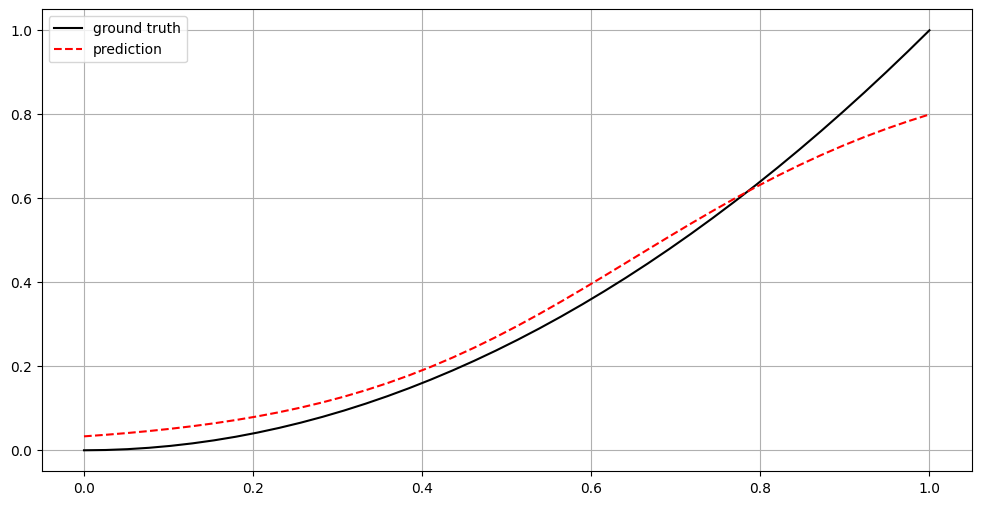

In [12]:
yPred = model.forward(x)

fig, ax = plt.subplots(figsize=(12, 6))
ax.grid()
ax.plot(x, y, "k", label="ground truth")
ax.plot(x, yPred, "r--", label="prediction")
ax.legend()
plt.show()

## Learning with PyTorch

**model definition**

In [13]:
modelTorch = neuralNetworkTorch(layers)
xTorch = torch.from_numpy(x).to(torch.float32)
yTorch = torch.from_numpy(y).to(torch.float32)
if selectOptimizer == "gradientDescent":
    optimizer = torch.optim.SGD(modelTorch.parameters(), lr)
elif selectOptimizer == "Adam":
    optimizer = torch.optim.Adam(modelTorch.parameters(), lr)

**training loop**

In [14]:
start = time.perf_counter()
for epoch in range(epochs):
    optimizer.zero_grad()
    yPredTorch = modelTorch.forward(xTorch)
    CTorch = 0.5 * torch.mean((yPredTorch - yTorch) ** 2)
    CTorch.backward()

    optimizer.step()

    if epoch % 100 == 0:
        elapsedTime = time.perf_counter() - start
        string = "Epoch: {}/{}\t\tCost = {:.2e}\t\tElapsed time = {:2f}"
        print(string.format(epoch, epochs, CTorch.detach(), elapsedTime))
        start = time.perf_counter()

Epoch: 0/10000		Cost = 5.41e-02		Elapsed time = 0.001512
Epoch: 100/10000		Cost = 4.68e-02		Elapsed time = 0.039268
Epoch: 200/10000		Cost = 4.67e-02		Elapsed time = 0.036121
Epoch: 300/10000		Cost = 4.67e-02		Elapsed time = 0.036899
Epoch: 400/10000		Cost = 4.66e-02		Elapsed time = 0.036314
Epoch: 500/10000		Cost = 4.66e-02		Elapsed time = 0.035340
Epoch: 600/10000		Cost = 4.65e-02		Elapsed time = 0.035961
Epoch: 700/10000		Cost = 4.65e-02		Elapsed time = 0.035332
Epoch: 800/10000		Cost = 4.64e-02		Elapsed time = 0.035434
Epoch: 900/10000		Cost = 4.64e-02		Elapsed time = 0.035259
Epoch: 1000/10000		Cost = 4.63e-02		Elapsed time = 0.035259
Epoch: 1100/10000		Cost = 4.63e-02		Elapsed time = 0.035987
Epoch: 1200/10000		Cost = 4.62e-02		Elapsed time = 0.037837
Epoch: 1300/10000		Cost = 4.62e-02		Elapsed time = 0.038007
Epoch: 1400/10000		Cost = 4.61e-02		Elapsed time = 0.037608
Epoch: 1500/10000		Cost = 4.61e-02		Elapsed time = 0.035750
Epoch: 1600/10000		Cost = 4.60e-02		Elapsed time = 0

**visualize the predictions**

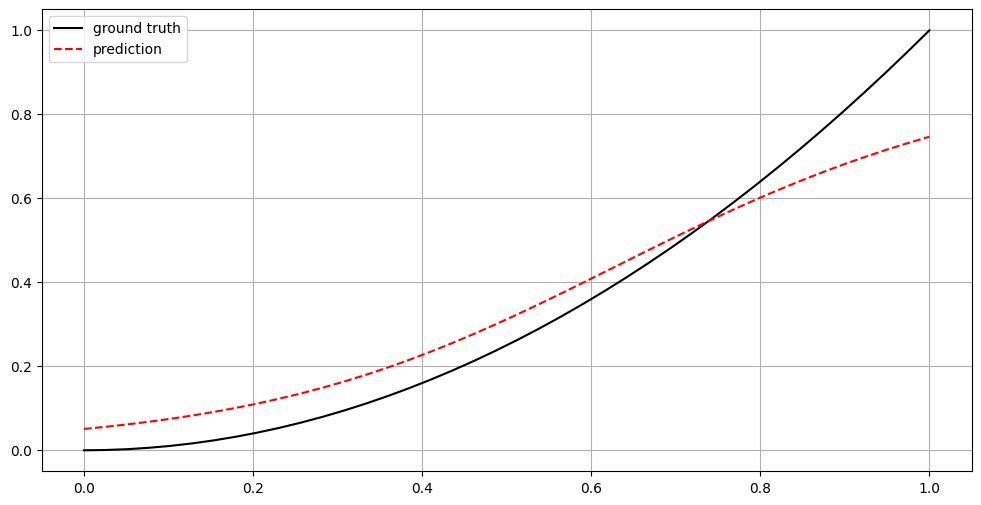

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.grid()
ax.plot(x, y, "k", label="ground truth")
ax.plot(xTorch, yPredTorch.detach(), "r--", label="prediction")
ax.legend()
plt.show()